# Autothermal Reformer Flowsheet Optimization with PySMO Surrogate Object

## 1. Introduction

This example demonstrates autothermal reformer optimization leveraging the PySMO Polynomial surrogate trainer. Other than the specific training method syntax, this workflow is identical for PySMO RBF and PySMO Kriging surrogate models. In this notebook, sampled simulation data will be used to train and validate a surrogate model. IDAES surrogate plotting tools will be utilized to visualize the surrogates on training and validation data. Once validated, integration of the surrogate into an IDAES flowsheet will be demonstrated.

# 2. Problem Statement 

Within the context of a larger NGFC system, the autothermal reformer generates syngas from air, steam and natural gas for use in a solid-oxide fuel cell (SOFC).

## 2.1. Main Inputs: 
- Bypass fraction (dimensionless) - split fraction of natural gas to bypass AR unit and feed directly to the power island
- NG-Steam Ratio (dimensionless) - proportion of natural relative to steam fed into AR unit operation

## 2.2. Main Outputs:
- Steam flowrate (kg/s) - inlet steam fed to AR unit
- Reformer duty (kW) - required energy input to AR unit
- Composition (dimensionless) - outlet mole fractions of components (Ar, C2H6, C3H8, C4H10, CH4, CO, CO2, H2, H2O, N2, O2)

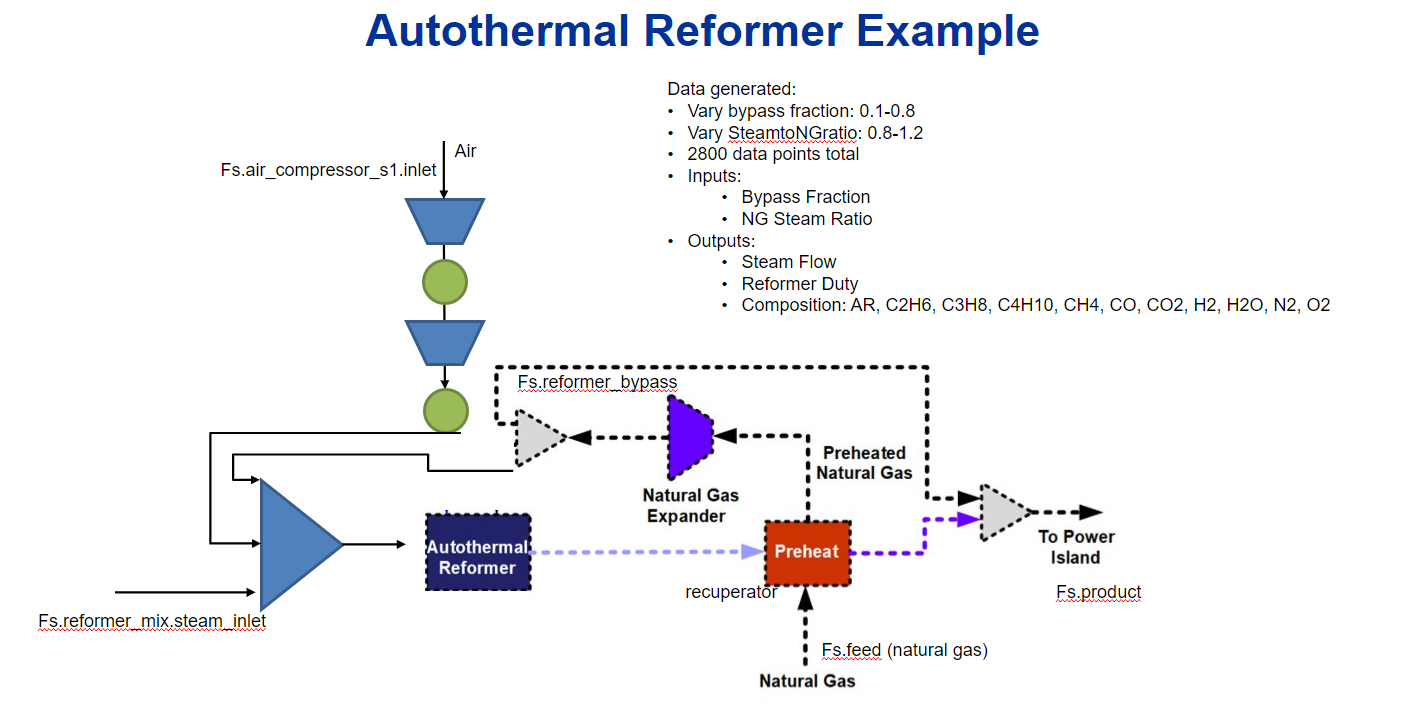

In [1]:
from IPython.display import Image
Image("AR_PFD.png")

## 3. Training and Validating Surrogates

First, let's import the required Python, Pyomo and IDAES modules:

In [2]:
# Import statements
import os
import numpy as np
import pandas as pd

# Import Pyomo libraries
from pyomo.environ import ConcreteModel, SolverFactory, value, Var, \
    Constraint, Set, Objective, maximize
from pyomo.common.timing import TicTocTimer

# Import IDAES libraries
from idaes.core.surrogate.sampling.data_utils import split_training_validation
from idaes.core.surrogate.pysmo_surrogate import PysmoPolyTrainer, PysmoSurrogate
from idaes.core.surrogate.plotting.sm_plotter import surrogate_scatter2D, surrogate_parity, surrogate_residual
from idaes.core.surrogate.surrogate_block import SurrogateBlock
from idaes.core import FlowsheetBlock
from idaes.core.util.convergence.convergence_base import _run_ipopt_with_stats

## 3.1 Importing Training and Validation Datasets

In this section, we read the dataset from the CSV file located in this directory. 2800 data points were simulated from a rigorous IDAES NGFC flowsheet using a grid sampling method. For simplicity and to reduce training runtime, this example randomly selects 100 data points to use for training/validation. The data is separated using an 80/20 split into training and validation data using the IDAES `split_training_validation()` method.

In [3]:
# Import Auto-reformer training data
np.set_printoptions(precision=6, suppress=True)

csv_data = pd.read_csv(r'reformer-data.csv') # 2800 data points
data = csv_data.sample(n = 100) # randomly sample points for training/validation
input_data = data.iloc[:, :2]
output_data = data.iloc[:, 2:]

# Define labels, and split training and validation data
# note that PySMO requires that labels are passed as string lists
input_labels = list(input_data.columns)
output_labels = list(output_data.columns)

n_data = data[input_labels[0]].size
data_training, data_validation = split_training_validation(data, 0.8, seed=n_data)  # seed=100

## 3.2 Training Surrogates with PySMO

IDAES builds a model class for each type of PySMO surrogate model. In this case, we will call and build the Polynomial Regression class. Regression settings can be directly passed as class arguments, as shown below. In this example, allowed basis terms span a 6th order polynomial as well as a variable product, and data is internally cross-validated using 10 iterations of 80/20 splits to ensure a robust surrogate fit. Note that PySMO uses cross-validation of training data to adjust model coefficients and ensure a more accurate fit, while we separate the validation dataset pre-training in order to visualize the surrogate fits.

Finally, after training the model we save the results and model expressions to a folder which contains a serialized JSON file. Serializing the model in this fashion enables importing a previously trained set of surrogate models into external flowsheets. This feature will be used later.

In [4]:
# Create PySMO trainer object
trainer = PysmoPolyTrainer(input_labels=input_labels,
                           output_labels=output_labels,
                           training_dataframe=data_training)

# Set PySMO options
trainer.config.maximum_polynomial_order = 6
trainer.config.multinomials = True
trainer.config.training_split = 0.8
trainer.config.number_of_crossvalidations = 10

# Train surrogate (calls PySMO through IDAES Python wrapper)
poly_train = trainer.train_surrogate()

# create callable surrogate object
xmin, xmax = [0.1, 0.8], [0.8, 1.2]
input_bounds = {input_labels[i]: (xmin[i], xmax[i])
                for i in range(len(input_labels))}
poly_surr = PysmoSurrogate(poly_train, input_labels, output_labels, input_bounds)

# save model to JSON
model = poly_surr.save_to_file('pysmo_poly_surrogate.json', overwrite=True)


===========================Polynomial Regression===============================================


No iterations will be run.
Default parameter estimation method is used.
Parameter estimation method:  pyomo 

max_fraction_training_samples set at  0.5
Number of adaptive samples (no_adaptive_samples) set at  4
Maximum number of iterations (Max_iter) set at:  0

Initial surrogate model is of order 5  with a cross-val error of 0.000000
Initial Regression Model Performance:
Order:  5  / MAE: 0.000000  / MSE: 0.000000  / R^2: 1.000000  / Adjusted R^2: 1.000000

Polynomial regression generates a good surrogate model for the input data.

-------------------------------------------------
-------------------------------------------------
Best solution found:  
Order:  5  / MAE: 0.000000  / MSE: 0.000000  / R_sq: 1.000000  / Adjusted R^2: 1.000000

------------------------------------------------------------
The final coefficients of the regression terms are: 

k               | 1.7e-05
(x_ 1 )^ 


Initial surrogate model is of order 6  with a cross-val error of 0.000000
Initial Regression Model Performance:
Order:  6  / MAE: 0.000001  / MSE: 0.000000  / R^2: 0.999996  / Adjusted R^2: 0.999996

Polynomial regression generates a good surrogate model for the input data.

-------------------------------------------------
-------------------------------------------------
Best solution found:  
Order:  6  / MAE: 0.000001  / MSE: 0.000000  / R_sq: 0.999996  / Adjusted R^2: 0.999996

------------------------------------------------------------
The final coefficients of the regression terms are: 

k               | -0.052397
(x_ 1 )^ 1      | 0.000584
(x_ 2 )^ 1      | 0.324176
(x_ 1 )^ 2      | 0.002222
(x_ 2 )^ 2      | -0.831831
(x_ 1 )^ 3      | -0.006623
(x_ 2 )^ 3      | 1.133238
(x_ 1 )^ 4      | 0.016294
(x_ 2 )^ 4      | -0.864508
(x_ 1 )^ 5      | -0.018563
(x_ 2 )^ 5      | 0.350174
(x_ 1 )^ 6      | 0.009684
(x_ 2 )^ 6      | -0.058841
x_ 1 .x_ 2      | -0.000193

Results sa


===========================Polynomial Regression===============================================


No iterations will be run.
Default parameter estimation method is used.
Parameter estimation method:  pyomo 

max_fraction_training_samples set at  0.5
Number of adaptive samples (no_adaptive_samples) set at  4
Maximum number of iterations (Max_iter) set at:  0

Initial surrogate model is of order 6  with a cross-val error of 0.000000
Initial Regression Model Performance:
Order:  6  / MAE: 0.000195  / MSE: 0.000000  / R^2: 0.999942  / Adjusted R^2: 0.999930

Polynomial regression generates a good surrogate model for the input data.

-------------------------------------------------
-------------------------------------------------
Best solution found:  
Order:  6  / MAE: 0.000195  / MSE: 0.000000  / R_sq: 0.999942  / Adjusted R^2: 0.999930

------------------------------------------------------------
The final coefficients of the regression terms are: 

k               | 26.500993
(x_ 1 )

c:\users\brandonlocal\github\idaes-pse\idaes\core\surrogate\pysmo\polynomial_regression.py:1404: UserWarning: Polynomial regression generates poor fit for the dataset
  warnings.warn(


## 3.3 Visualizing surrogates

Now that the surrogate models have been trained, the models can be visualized through scatter, parity and residual plots to confirm their validity in the chosen domain. The training data will be visualized first to confirm the surrogates are fit the data, and then the validation data will be visualized to confirm the surrogates accurately predict new output values.

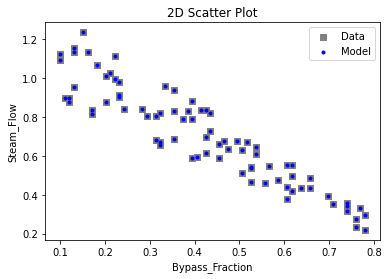

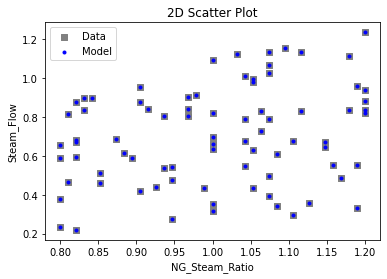

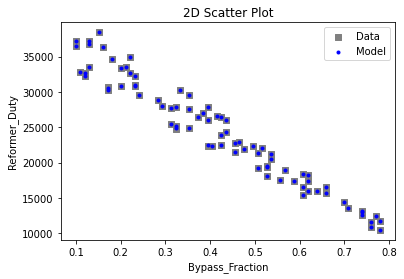

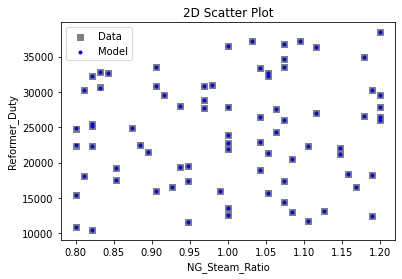

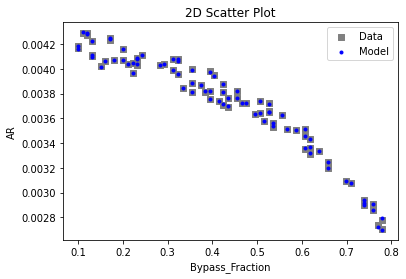

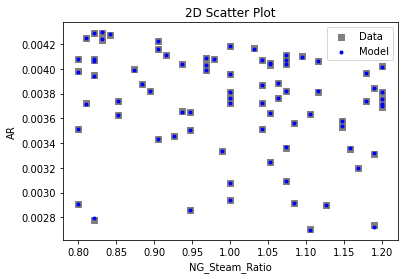

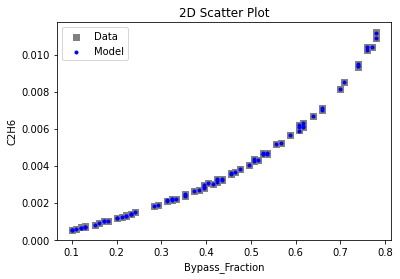

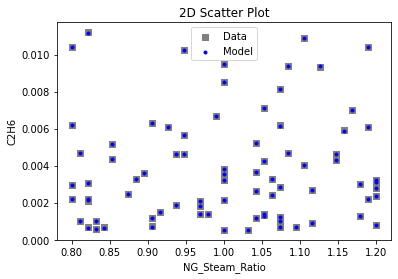

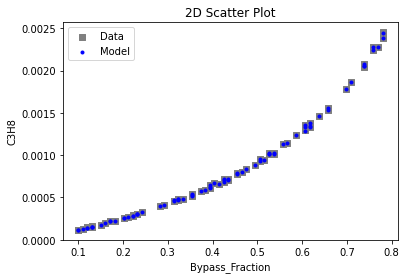

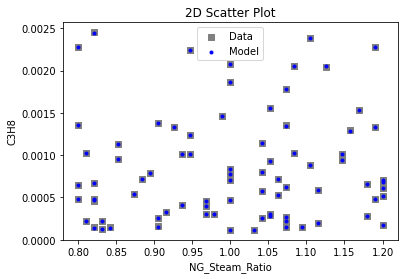

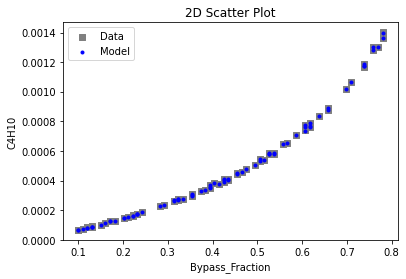

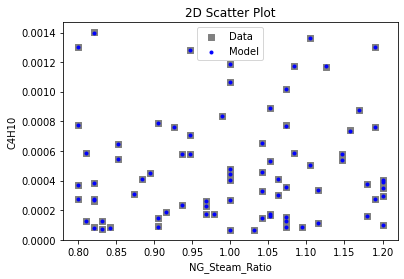

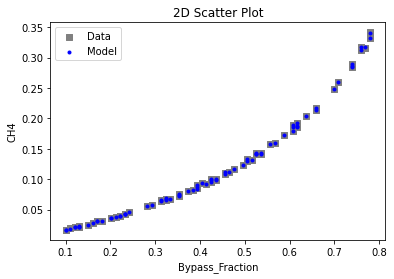

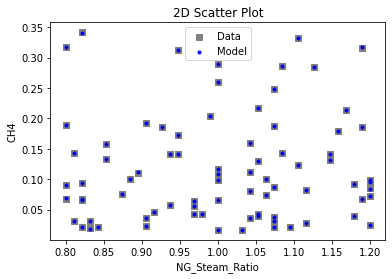

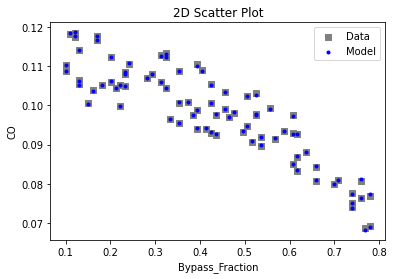

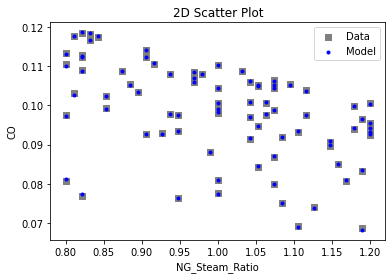

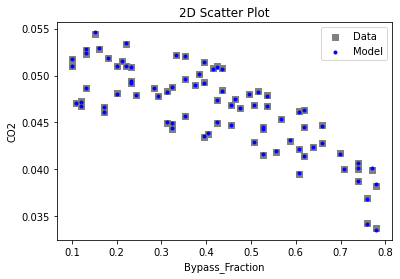

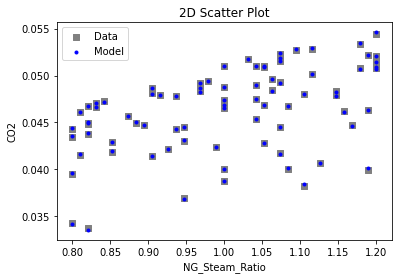

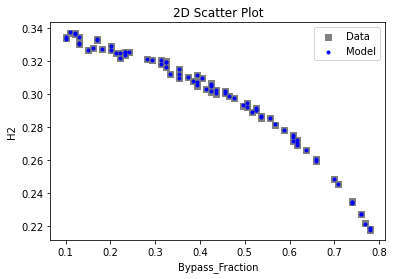

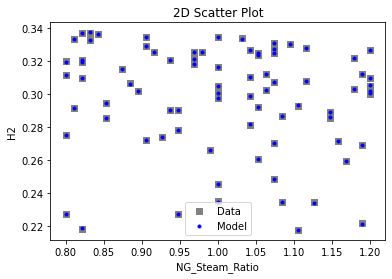

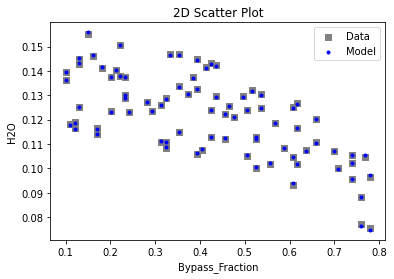

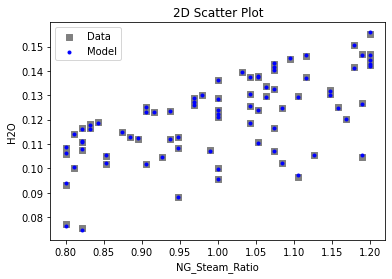

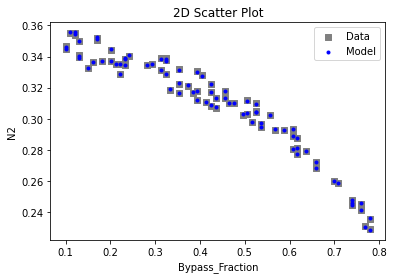

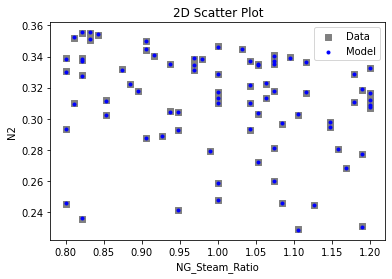

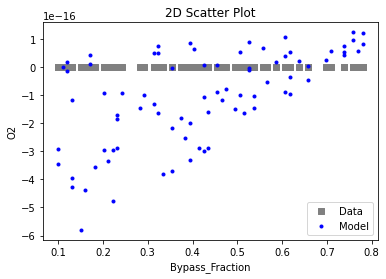

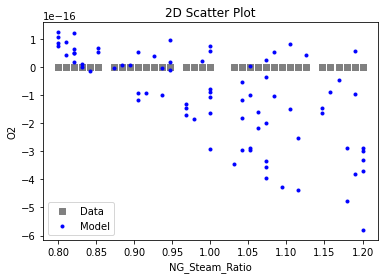

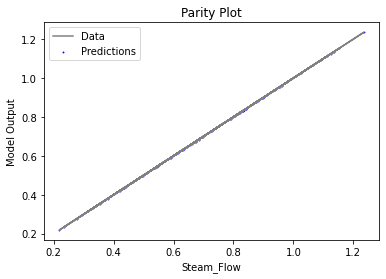

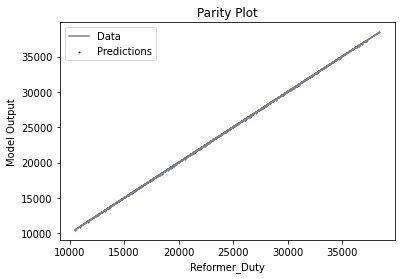

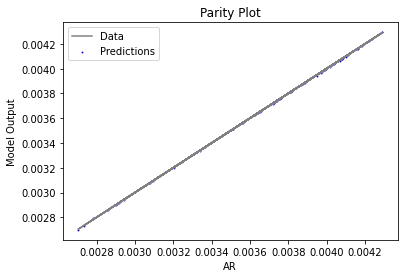

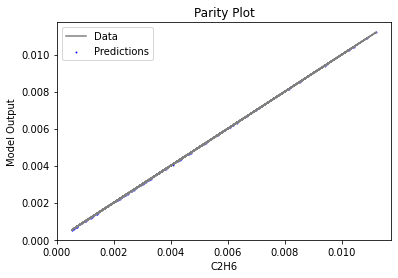

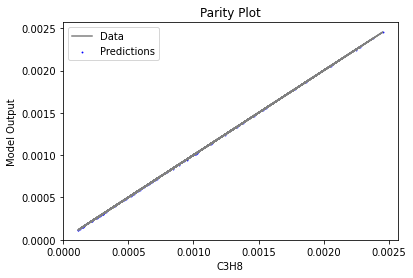

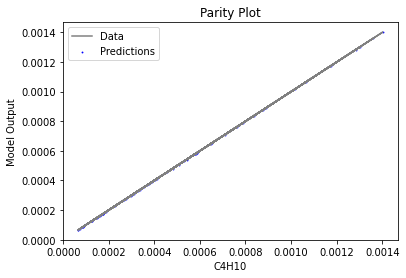

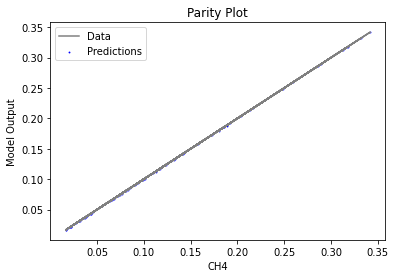

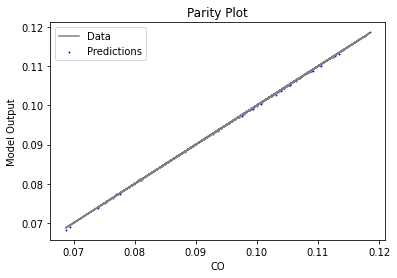

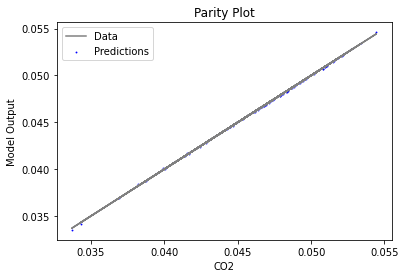

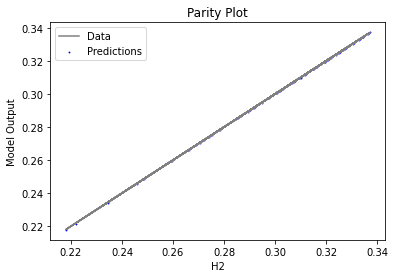

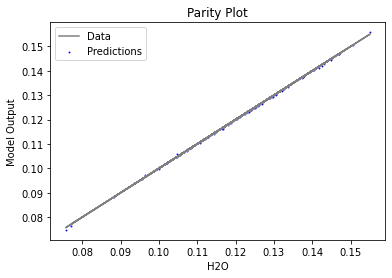

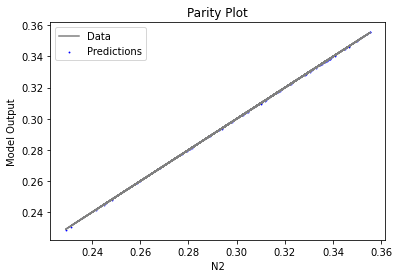

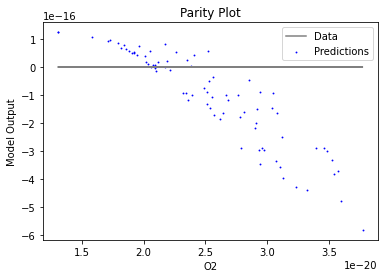

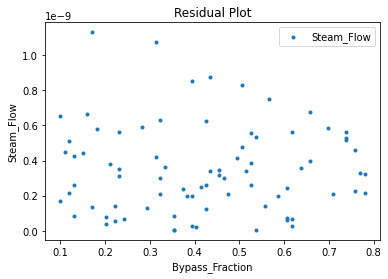

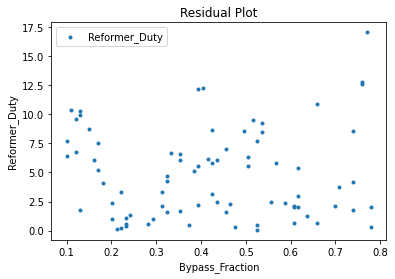

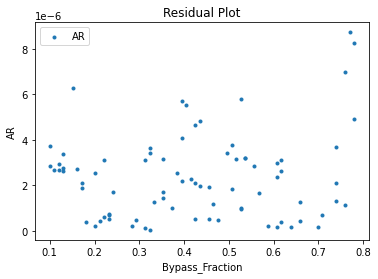

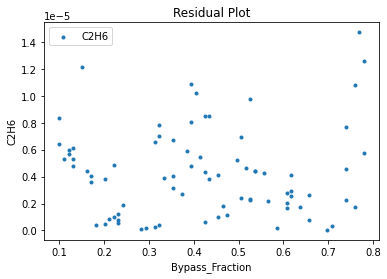

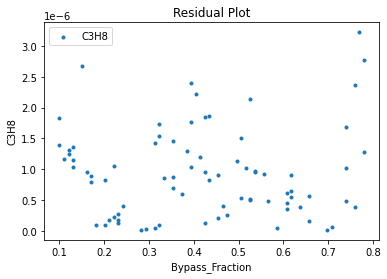

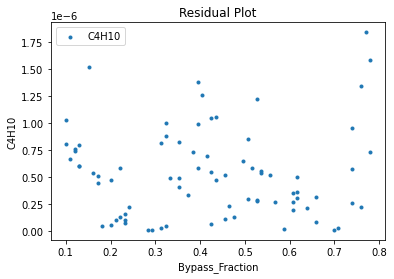

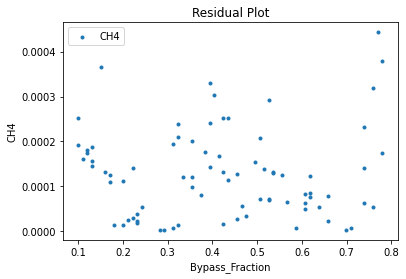

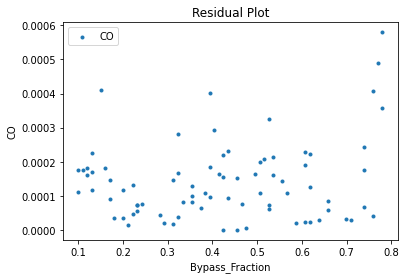

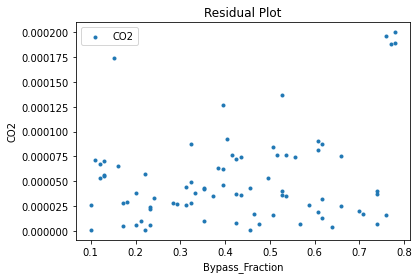

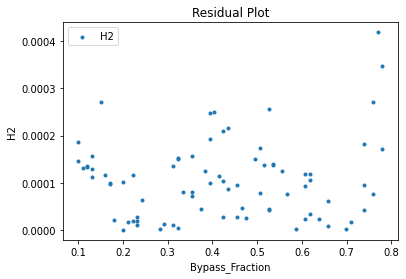

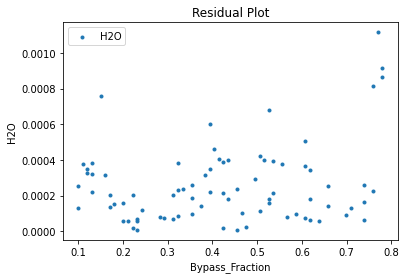

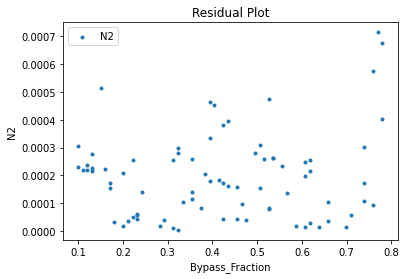

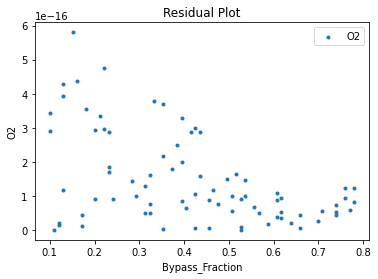

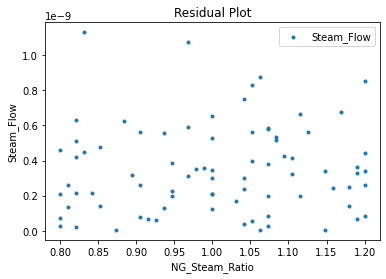

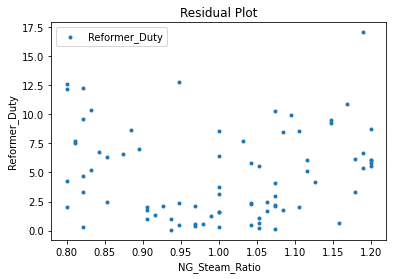

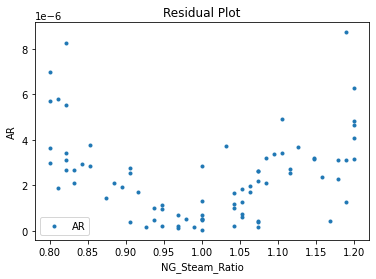

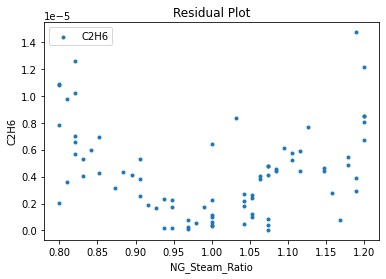

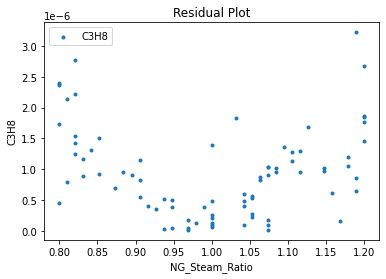

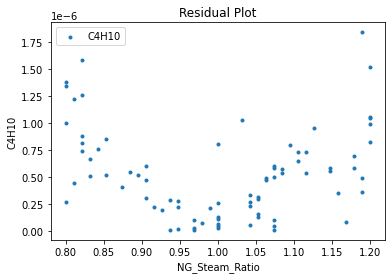

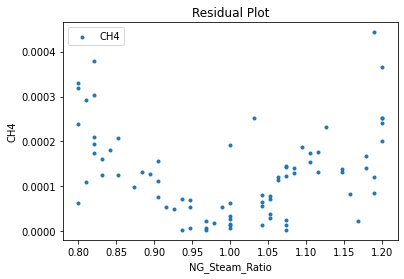

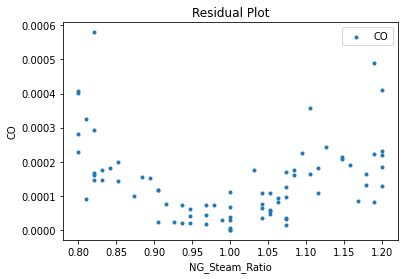

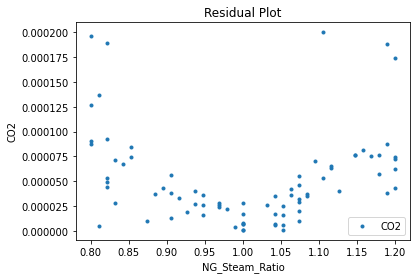

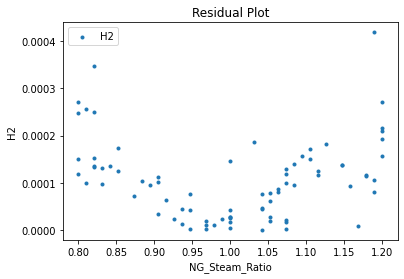

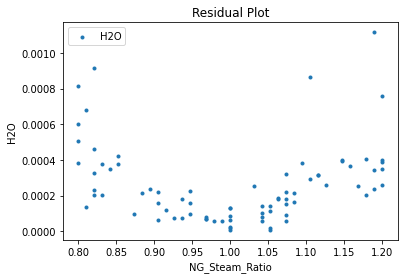

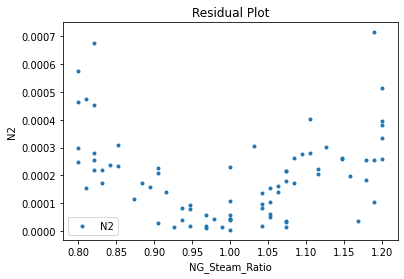

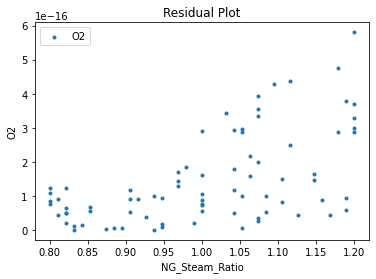

In [5]:
# visualize with IDAES surrogate plotting tools
surrogate_scatter2D(poly_surr, data_training, filename='pysmo_poly_train_scatter2D.pdf')
surrogate_parity(poly_surr, data_training, filename='pysmo_poly_train_parity.pdf')
surrogate_residual(poly_surr, data_training, filename='pysmo_poly_train_residual.pdf')

## 3.4 Model Validation

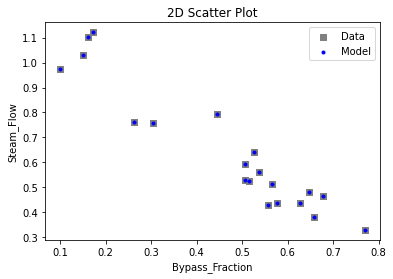

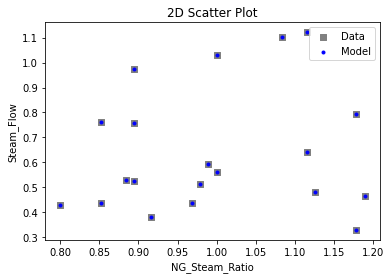

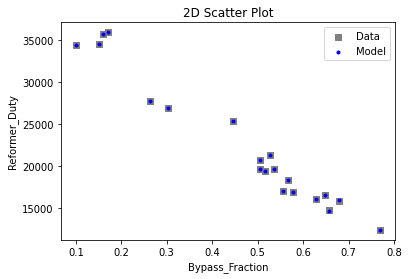

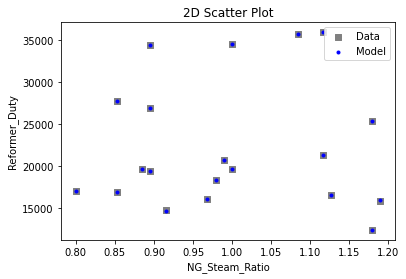

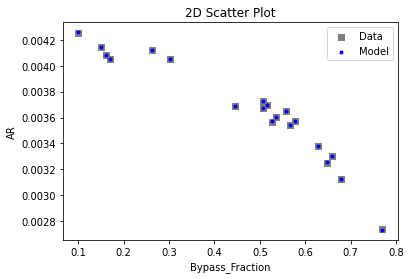

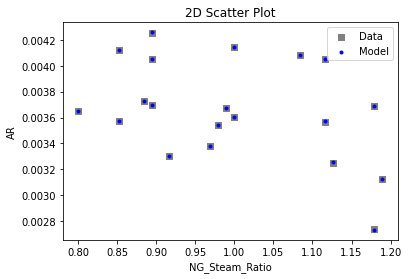

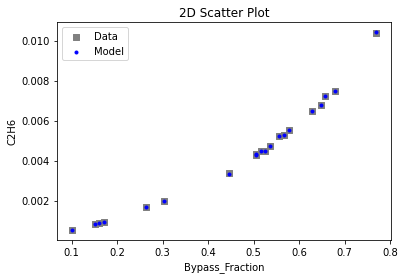

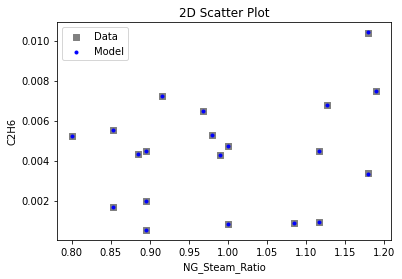

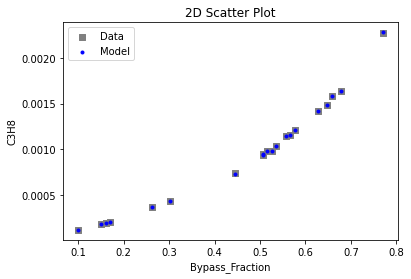

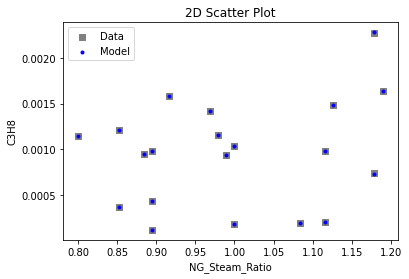

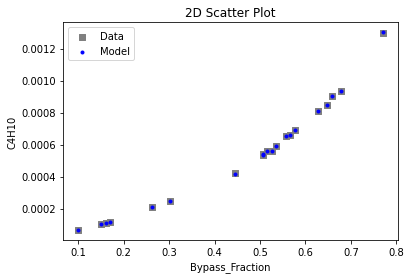

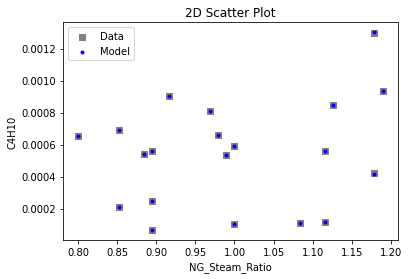

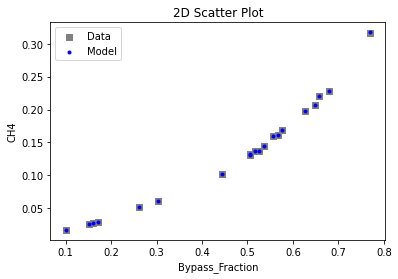

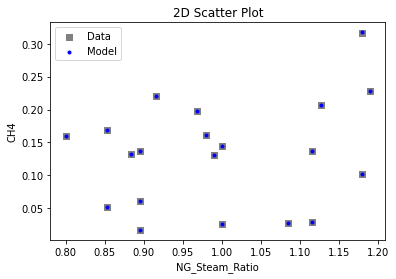

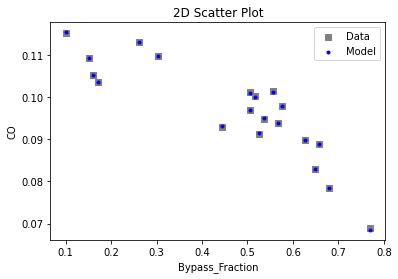

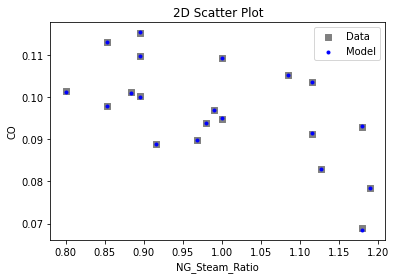

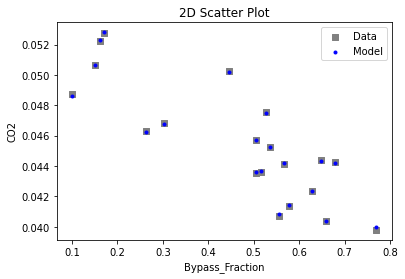

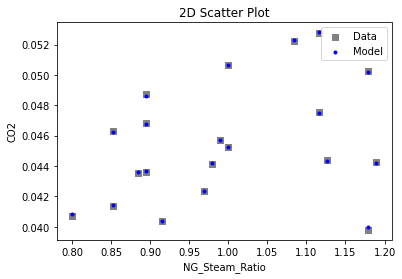

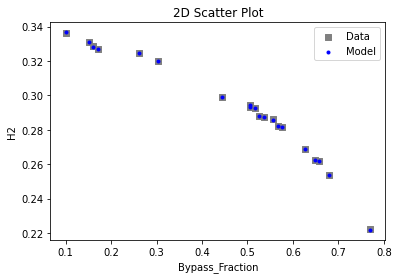

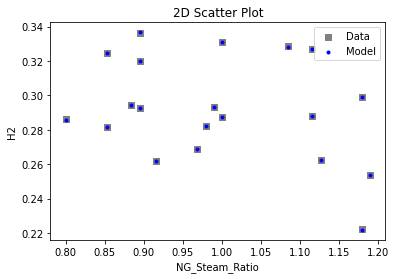

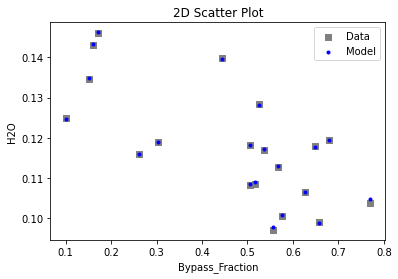

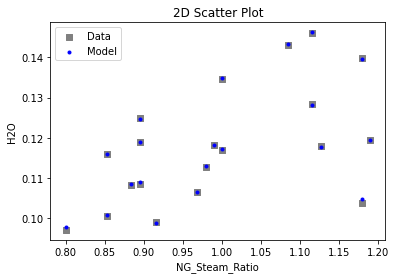

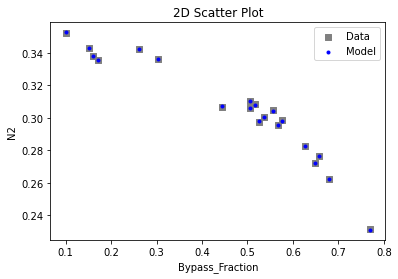

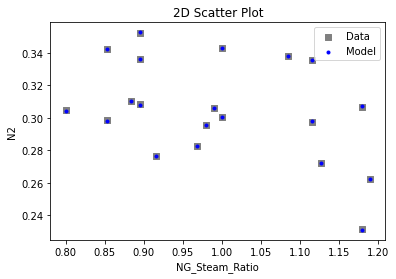

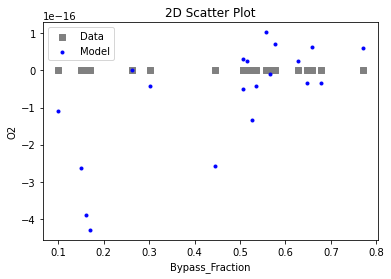

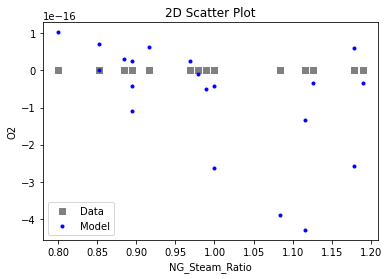

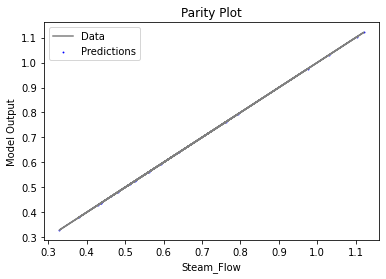

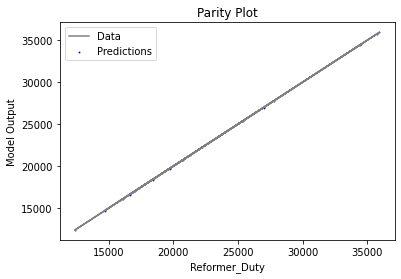

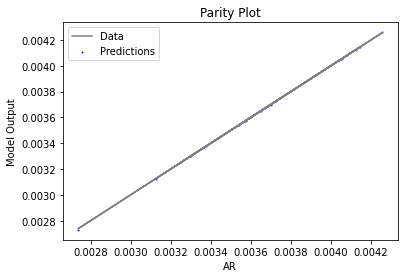

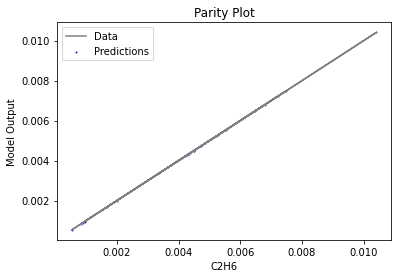

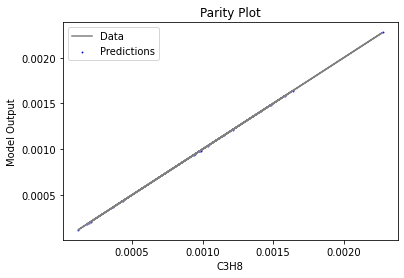

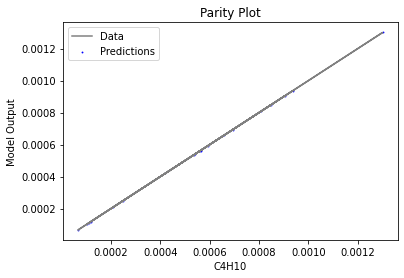

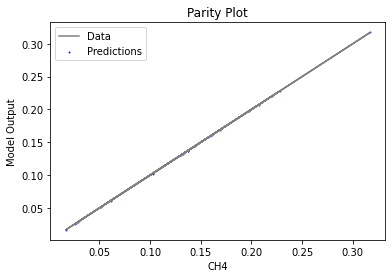

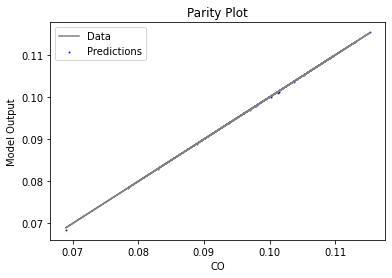

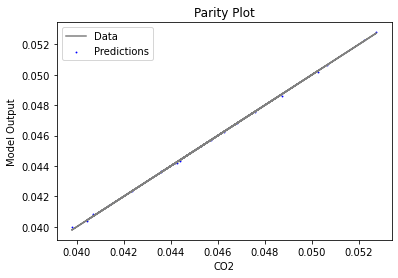

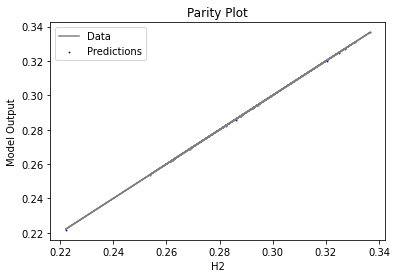

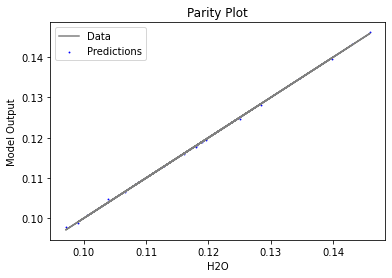

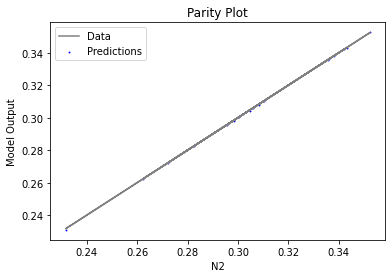

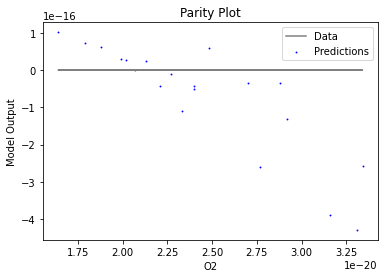

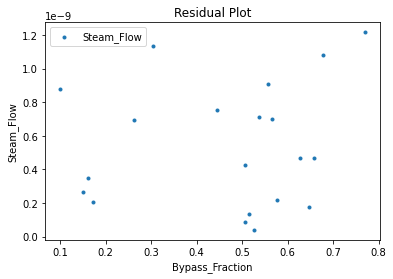

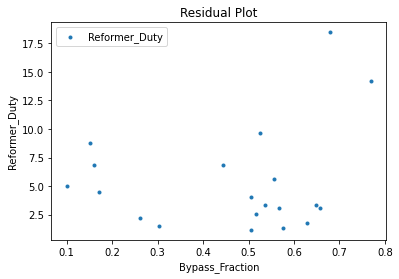

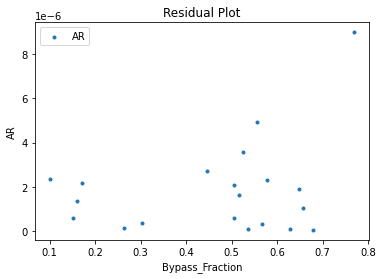

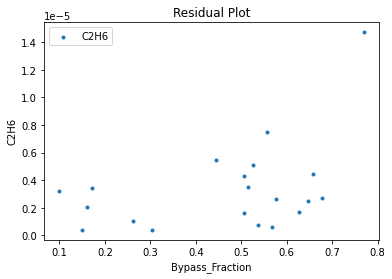

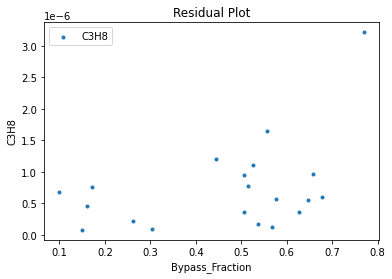

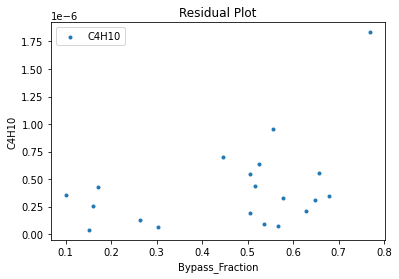

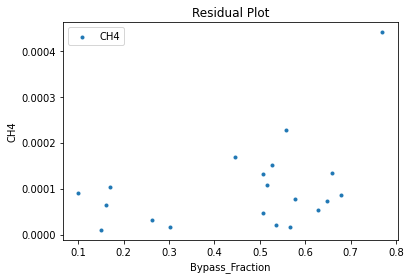

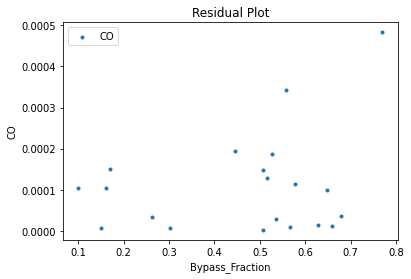

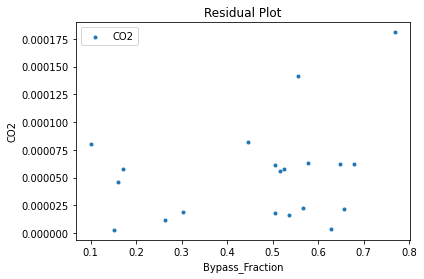

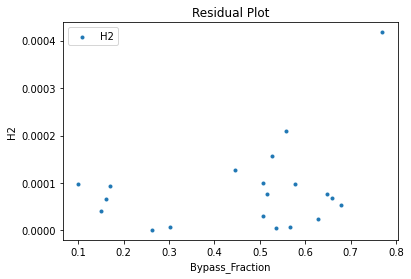

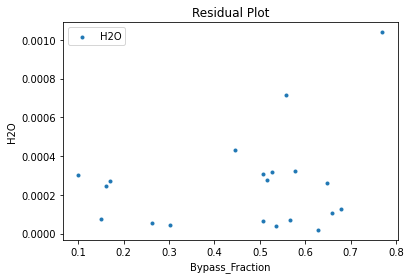

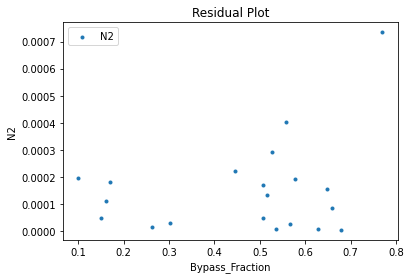

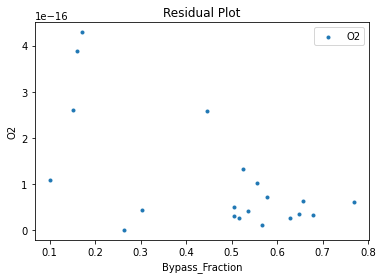

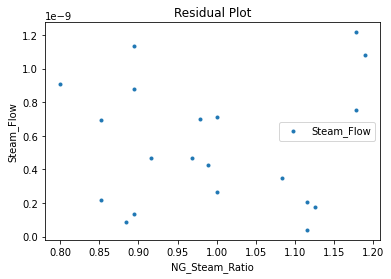

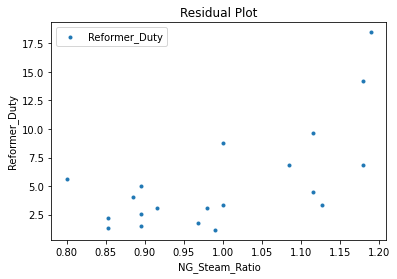

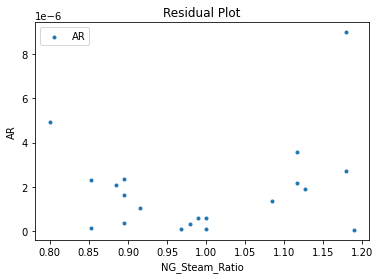

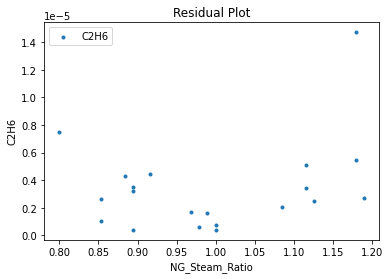

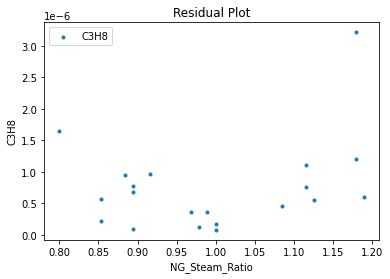

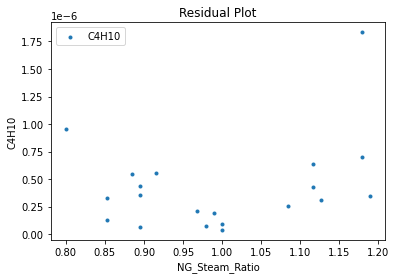

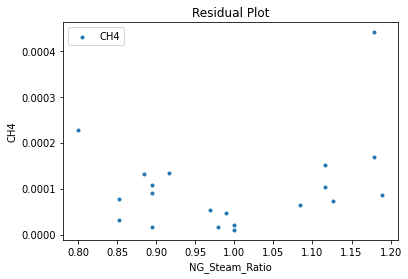

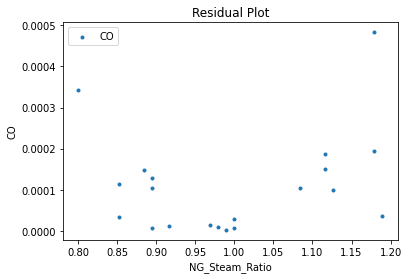

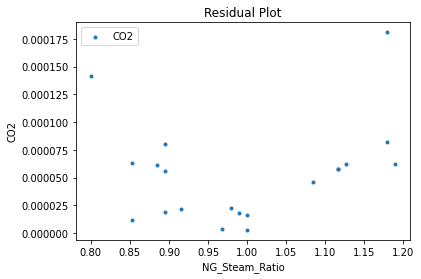

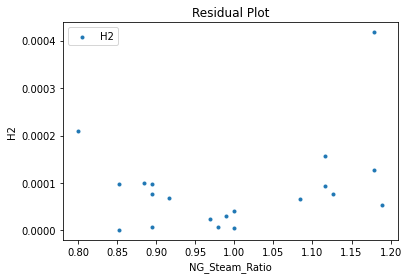

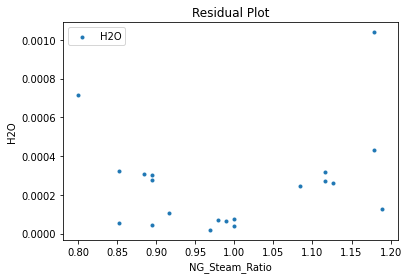

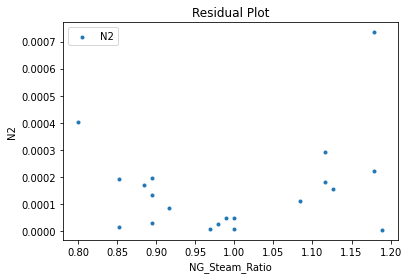

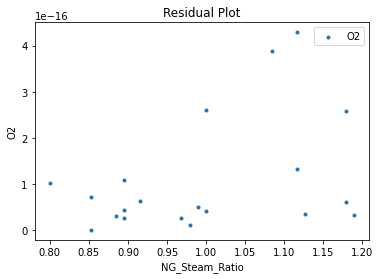

In [6]:
# visualize with IDAES surrogate plotting tools
surrogate_scatter2D(poly_surr, data_validation, filename='pysmo_poly_val_scatter2D.pdf')
surrogate_parity(poly_surr, data_validation, filename='pysmo_poly_val_parity.pdf')
surrogate_residual(poly_surr, data_validation, filename='pysmo_poly_val_residual.pdf')

# 4. IDAES Flowsheet Integration

## 4.1 Build and Run IDAES Flowsheet

Next, we will build an IDAES flowsheet and import the surrogate model object. Each output variable has a unique PySMO model expression, and the surrogate expressions may be added to the model via an indexed Constraint() component.

In [7]:
# create the IDAES model and flowsheet
m = ConcreteModel()
m.fs = FlowsheetBlock(default={"dynamic": False})

# create flowsheet input variables
m.fs.bypass_frac = Var(initialize=0.80, bounds=[0.1, 0.8], doc='natural gas bypass fraction')
m.fs.ng_steam_ratio = Var(initialize=0.80, bounds=[0.8, 1.2], doc='natural gas to steam ratio')

# create flowsheet output variables
m.fs.steam_flowrate = Var(initialize=0.2, doc="steam flowrate")
m.fs.reformer_duty = Var(initialize=10000, doc="reformer heat duty")
m.fs.AR = Var(initialize=0, doc="AR fraction")
m.fs.C2H6 = Var(initialize=0, doc="C2H6 fraction")
m.fs.C3H8 = Var(initialize=0, doc="C3H8 fraction")
m.fs.C4H10 = Var(initialize=0, doc="C4H10 fraction")
m.fs.CH4 = Var(initialize=0, doc="CH4 fraction")
m.fs.CO = Var(initialize=0, doc="CO fraction")
m.fs.CO2 = Var(initialize=0, doc="CO2 fraction")
m.fs.H2 = Var(initialize=0, doc="H2 fraction")
m.fs.H2O = Var(initialize=0, doc="H2O fraction")
m.fs.N2 = Var(initialize=0, doc="N2 fraction")
m.fs.O2 = Var(initialize=0, doc="O2 fraction")

# create input and output variable object lists for flowsheet
inputs = [m.fs.bypass_frac, m.fs.ng_steam_ratio]
outputs = [m.fs.steam_flowrate, m.fs.reformer_duty, m.fs.AR, m.fs.C2H6, m.fs.C4H10,
           m.fs.C3H8, m.fs.CH4, m.fs.CO, m.fs.CO2, m.fs.H2, m.fs.H2O, m.fs.N2, m.fs.O2]

# create the Pyomo/IDAES block that corresponds to the surrogate
# PySMO
surrogate = PysmoSurrogate.load_from_file('pysmo_poly_surrogate.json')
m.fs.surrogate = SurrogateBlock(concrete=True)
m.fs.surrogate.build_model(surrogate, input_vars=inputs, output_vars=outputs)

# fix input values and solve flowsheet
m.fs.bypass_frac.fix(0.5)
m.fs.ng_steam_ratio.fix(1)

solver = SolverFactory('ipopt')
[status_obj, solved, iters, time] = _run_ipopt_with_stats(m, solver)

2022-05-04 06:14:43 [INFO] idaes.core.surrogate.pysmo_surrogate: Decode surrogate. type=poly

===========================Polynomial Regression===============================================


The number of cross-validation cases (3) is used.
The default training/cross-validation split of 0.75 is used.
No iterations will be run.
Default parameter estimation method is used.
Parameter estimation method:  pyomo 


===========================Polynomial Regression===============================================


The number of cross-validation cases (3) is used.
The default training/cross-validation split of 0.75 is used.
No iterations will be run.
Default parameter estimation method is used.
Parameter estimation method:  pyomo 


===========================Polynomial Regression===============================================


The number of cross-validation cases (3) is used.
The default training/cross-validation split of 0.75 is used.
No iterations will be run.
Default parameter estimation m

Let's print some model results:

In [8]:
print("Model status: ", status_obj)
print("Solution optimal: ", solved)
print("IPOPT iterations: ", iters)
print("IPOPT runtime: ", time)

print()
print("Steam flowrate = ", value(m.fs.steam_flowrate))
print("Reformer duty = ", value(m.fs.reformer_duty))
print("Mole Fraction Ar = ", value(m.fs.AR))
print("Mole Fraction C2H6 = ", value(m.fs.C2H6))
print("Mole Fraction C3H8 = ", value(m.fs.C3H8))
print("Mole Fraction C4H10 = ", value(m.fs.C4H10))
print("Mole Fraction CH4 = ", value(m.fs.CH4))
print("Mole Fraction CO = ", value(m.fs.CO))
print("Mole Fraction CO2 = ", value(m.fs.CO2))
print("Mole Fraction H2 = ", value(m.fs.H2))
print("Mole Fraction H2O = ", value(m.fs.H2O))
print("Mole Fraction N2 = ", value(m.fs.N2))
print("Mole Fraction O2 = ", value(m.fs.O2))

Model status:  
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 13
  Number of variables: 13
  Sense: unknown
Solver: 
- Status: ok
  Message: Ipopt 3.13.2\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.19127655029296875
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

Solution optimal:  True
IPOPT iterations:  1
IPOPT runtime:  0.003

Steam flowrate =  0.6059308502597877
Reformer duty =  21071.598827429265
Mole Fraction Ar =  0.0036787234371758668
Mole Fraction C2H6 =  0.004188159307223063
Mole Fraction C3H8 =  0.0005235098676730846
Mole Fraction C4H10 =  0.0009161529581612829
Mole Fraction CH4 =  0.12788311486724963
Mole Fraction CO =  0.09696482523394827
Mole Fraction CO2 =  0.04604308390596763
Mole Fraction H2 =  0.29384509591118474
Mole Fraction H2O =  0.11961691077266155
Mole Fraction N2 =  0.3063908047702503
Mole Fraction O2 =  -6.245004513516506e-17


## 4.2 Optimizing the Autothermal Reformer
Extending this example, we will unfix the input variables and optimize hydrogen production. We will restrict nitrogen below 34 mol% of the product stream and leave all other variables unfixed.

Above, variable values are called in reference to actual objects names; however, as shown below this may be done much more compactly by calling the list objects we created earlier.

In [9]:
# unfix input values and add the objective/constraint to the model
m.fs.bypass_frac.unfix()
m.fs.ng_steam_ratio.unfix()
m.fs.obj = Objective(expr=m.fs.H2, sense=maximize)
m.fs.con = Constraint(expr=m.fs.N2 <= 0.34)

# solve the model
tmr = TicTocTimer()
status = solver.solve(m, tee=False)
solve_time = tmr.toc('solve')

# print and check results
assert abs(value(m.fs.H2)-0.33) <= 0.01
assert value(m.fs.N2 <= 0.4+1e-8)
print('Model status: ', status)
print('Solve time: ', solve_time)
for var in inputs:
    print(var.name,': ', value(var))
for var in outputs:
    print(var.name,': ', value(var))

[+   0.22] solve
Model status:  
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 14
  Number of variables: 15
  Sense: unknown
Solver: 
- Status: ok
  Message: Ipopt 3.13.2\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.20169878005981445
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

Solve time:  0.21672279999998523
fs.bypass_frac :  0.10000006257827865
fs.ng_steam_ratio :  1.1132790199046785
fs.steam_flowrate :  1.2142261011112214
fs.reformer_duty :  38859.6241015956
fs.AR :  0.004107121575923729
fs.C2H6 :  0.0005350874924360644
fs.C4H10 :  0.00011705795940515904
fs.C3H8 :  6.692669940301565e-05
fs.CH4 :  0.01668251609309499
fs.CO :  0.10490588331335769
fs.CO2 :  0.053422256629055885
fs.H2 :  0.33161807937136273
fs.H2O :  0.1483542893481537
fs.N2 :  0.34000000428595284
fs.O2 :  -4.840381888885635e-16
